# Solving Elliptic equation



## Computing the $H^{-s}$ with piecewise linear tent functions

We will compute 
$$
||f||_{H^{-1}}^2 \approx [f, \psi]\Theta^{-1}[f, \psi]
$$

where 
\begin{align}
 &[f, \psi] = (\int f \psi_1, \dots, \int f \psi_N) \\
 &\Theta_{ij} = \int \psi_i (-\Delta \psi_j) = \int \nabla \psi_i \nabla \psi_j
\end{align}


We define tent functions

\begin{align}
\psi_i^{\varepsilon} = \varepsilon^{-1}\text{max}\{1- \frac{|x -c_i|}{\varepsilon},0  \}  = \begin{cases}\varepsilon^{-1}(1 + \frac{x- c_i}{\varepsilon}) \quad c_i - \varepsilon \leq x \leq c_i \\\varepsilon^{-1}(1 - \frac{x- c_i}{\varepsilon})  \quad c_i \leq x \leq c_i + \varepsilon\\0
 \end{cases}
\end{align}



Observe that 
\begin{align}
\int_{\Omega} \psi_0^1 = \int_{-1}^{0} 1 - x + \int_{0}^1 x-1 = 2\int_{0}^{1} x-1 = 1
\end{align}

And so 
$$
\int_{\Omega} \psi_{c}^\varepsilon = 1
$$
which makes it a an approximation of the identity.

Moreover 
\begin{align}
\nabla \psi_i^{\varepsilon} = \begin{cases}\varepsilon^{-2} \text{sign}(c_i -x) \quad x \in [c_i- \varepsilon, c_i+ \varepsilon] \\0 \end{cases}
\end{align}

Therefore 

\begin{align}
&\int \psi_i^\varepsilon \psi_j^\varepsilon = \begin{cases} \frac{2}{3\varepsilon} \quad &|c_i - c_j| =0  \\ \frac{2}{3\varepsilon} \quad &|c_i - c_j| =\varepsilon  \\
0\end{cases} \\
&\int \nabla \psi_i^\varepsilon \nabla \psi_j^\varepsilon = \begin{cases} \frac{2}{\varepsilon} \quad  &|c_i - c_j| = 0\\  -\frac{1}{\varepsilon}  \quad &|c_i - c_j| = \varepsilon \\ 0 &\end{cases}
\end{align}

In [1]:
import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy


from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_29388\3857653928.py:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# Define the domain of the problem
L = 1.0
lower = 0.0
upper = L
x = jnp.linspace(0, 1, 10000)
boundary = jnp.array([[lower, upper]]).T


In [3]:
N_m = 500
centers = jnp.linspace(0, L, int(N_m))[1:-1]
N_tent = len(centers)
epsilon = centers[1] - centers[0]
epsilon

Array(0.00200401, dtype=float64)

In [4]:
stiffness_matrix = vmap_compute_energy_ip(epsilon, centers, centers)
L2_matrix = vmap_compute_l2_ip(epsilon, centers, centers)
L_stiff = scipy.linalg.cho_factor(stiffness_matrix + 1e-10*jnp.eye(N_tent))
#L = scipy.linalg.cholesky(L2_matrix, lower=True)
#stiffness_matrix, L2_matrix

# Solving semilinear elliptic

With the Gauss-Newton iteration, we need to solve 

\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n)  - f, \boldsymbol{\psi}]^\intercal \Theta^{-1} [\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

The case we wish to address is 

\begin{align}
&\mathcal{P}(u) = Lu + \tau(u)\\
&\mathcal{P}'(u) = Lu + \tau'(u)
\end{align}

In which case the above problem is 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

Denote $r_n = f -\tau(u_n) + \tau'(u_n)u_n$. Then
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - r_n, \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v -r_n, \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}


<!-- The important special case is when 

\begin{align}
&\mathcal{P}(u) = -\nu \Delta u + u + \tau(u)\\
&\mathcal{P}'(u) = -\nu \Delta u + u + \tau'(u)
\end{align}

In which case the above problem is 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[-\nu \Delta v + v + \tau'(u_n)v + (\tau(u_n) - \tau'(u_n)u_n)  - f, \boldsymbol{\psi}]^\intercal \Theta^{-1} [\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align} -->

Therefore we need to be able to compute 

$$
L_y L_x K(x,y)
$$

We will define $L$ to be a diff operator taking $K$ and returning 

\begin{aligned}
&L_x K(x,y) \\
&L_y L_x K(x,y)
\end{aligned}

In this case:
$$
L_x = -\nu\Delta_x + b(x)I
$$
so 
$$
L_y L_x = (-\nu\Delta_y + b(y)I)(-\nu\Delta_x + b(x)I) = \nu^2\Delta_y \Delta_x  - \varepsilon b(x)\Delta_y - \varepsilon b(y)\Delta_x + b(x)b(y)I
$$


# Elliptic equation with coefficients

We will solve 

$$
-\nu\Delta u + b(x)u = \xi 
$$

where $b$ will be non-constant, but smooth.

$$
\xi = \sum_{i=1}^\infty \xi_i \chi_i
$$

If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
f =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2}\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big) + b(x)\sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$


Text(0.5, 1.0, 'b(x)')

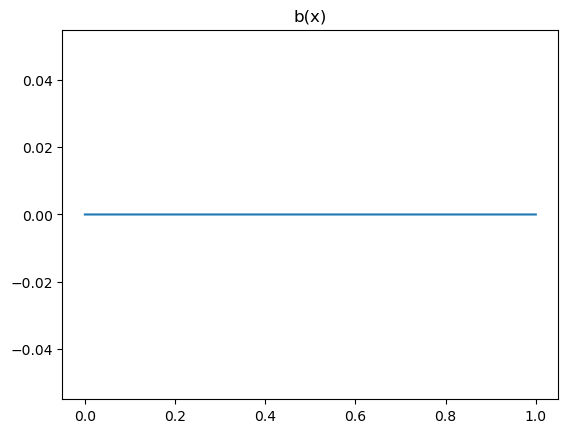

In [5]:
b = lambda x: -jnp.ones_like(x)*0.0 #jnp.cos(4*jnp.pi*x)
b_values = b(x)
plt.plot(x, b_values)
plt.title("b(x)")

3.1


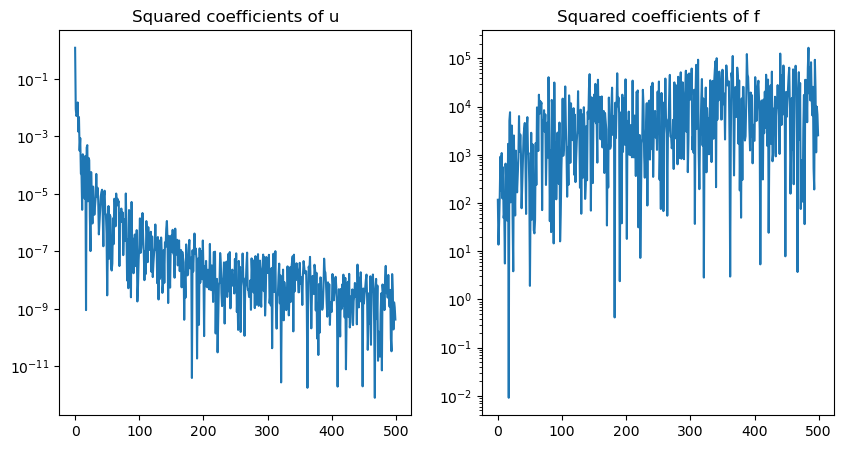

Text(0.5, 1.0, 'Function f')

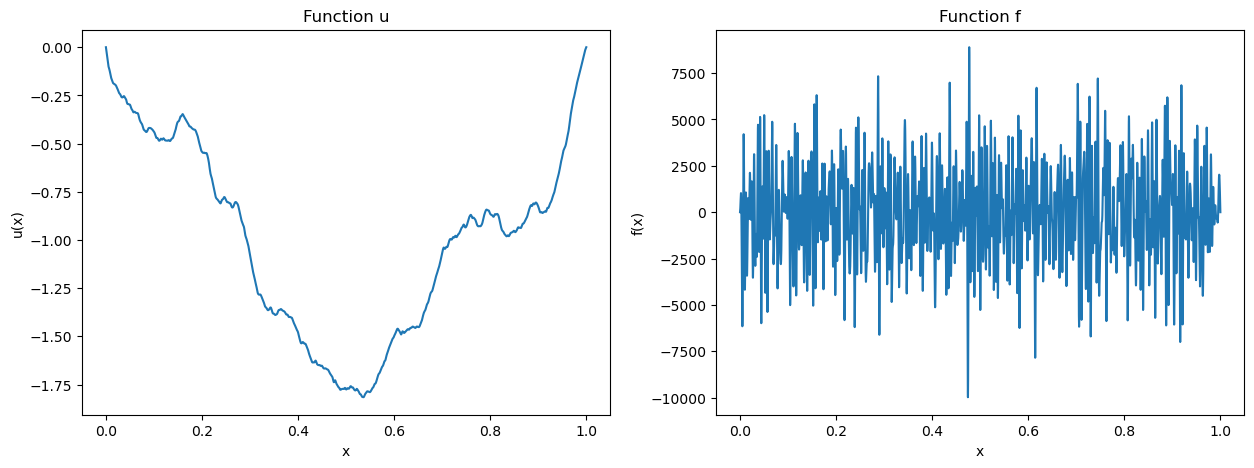

In [6]:
# Create the RHS

nu = 1e0

# draw random values for the coefficients
key = random.PRNGKey(54)

n_coef = 500

s = 1
alpha = 2*s+1 + 0.1
print(alpha)
decay_u = alpha/2
L = 1 # Lenght of the domain
coef_u =  jnp.ones(shape = (1, ))/(jnp.arange(1, n_coef+1)**(decay_u)) #jnp.ones(shape = (1, ))#random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))

coef_u = random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))
coef_f_constant = coef_u*(nu*jnp.arange(1, n_coef+1)**(2)*jnp.pi**2*L**2)

#x = jnp.linspace(0, L, 2000)
u_values = evaluate_function(x, coef_u, L=L)
f_values = evaluate_function(x, coef_f_constant, L=L) + b(x)*u_values

# Plot both the coeffients of u and f in 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(coef_u**2)
ax1.set_yscale('log')
ax1.set_title('Squared coefficients of u')
ax2.plot(coef_f_constant**2)
ax2.set_yscale('log')
ax2.set_title('Squared coefficients of f')

plt.show()

# Create 2 plots for the  function u and f
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values)
ax[0].set_xlabel("x")
ax[0].set_ylabel("u(x)")
ax[0].set_title("Function u")

ax[1].plot(x, f_values)
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].set_title("Function f")

# Create measurements: integrate against test function

In [7]:
# Define the support of the test function 
support = jnp.array([centers - epsilon
                     , centers + epsilon]).T

from scipy.special import roots_legendre
n_order = 10
x_q, w_q = roots_legendre(n_order)
x_interval, w_interval = vmap_root_interval(x_q, w_q, support)

from utils_rough_pde import vmap_integrate_f_test_functions
# Create measurements of f 
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)
psi_matrix = vmap_tent_vector(root_psi, epsilon, centers)
psi_matrix = psi_matrix * w_psi

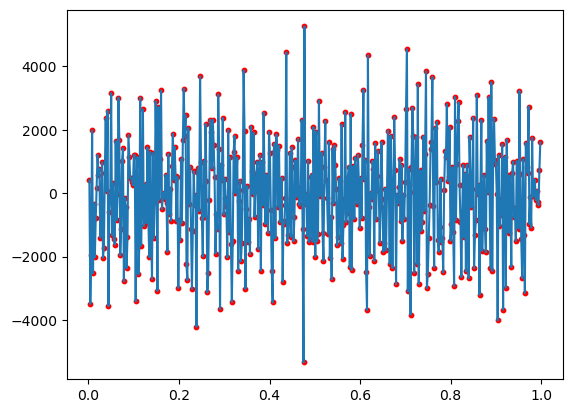

In [8]:
# Create the measurements of f
f_quad = evaluate_function(root_psi, coef_f_constant, L) + b(root_psi)*evaluate_function(root_psi, coef_u, L)
f_meas = vmap_integrate_f_test_functions(f_quad, psi_matrix)

plt.plot(centers, f_meas)
plt.scatter(centers, f_meas, color='r', s = 10)

In [9]:
# Create the array of b values
root_b = b(root_psi)

In [10]:

# Construct the matrices 
length_scale = 0.2
theta_11, theta_21, theta_22 = theta_blocks(boundary,psi_matrix, root_psi, length_scale, nu, root_b)
theta_12 = theta_21.T
K = jnp.block([[theta_11, theta_12], [theta_21, theta_22]])

K_interior = jnp.vstack([theta_12, theta_22]).T
K_bc = jnp.vstack([theta_11, theta_21]).T

reg = 1e-7
bc = jnp.zeros(shape = (2, )) 

In [11]:

# def solve_qp(K, K_interior, K_bc, L_stiff, f_m, bc, reg, reg_stab = 1e-10):
#     #print(L_stiff)
#     rhs= jnp.hstack([K_interior.T@scipy.linalg.cho_solve(L_stiff, f_m), bc])
#     Q = jnp.block([ [K_interior.T@scipy.linalg.cho_solve(L_stiff, K_interior) + reg*K, K_bc.T], [K_bc, jnp.zeros((2, 2))]])

#     sol = scipy.linalg.solve(Q + reg_stab*jnp.eye(Q.shape[0]), rhs, assume_a='sym')
#     c = sol[:-2]

#     return c

In [12]:
from utils_optim import solve_qp
c = solve_qp(K, K_interior, K_bc, L_stiff, f_meas, bc, reg)
c

Array([-2.99115298e+00, -3.56580737e+00,  4.12727524e+00, -4.35394701e+00,
       -7.33859532e+00,  1.79970702e+01, -1.86073098e+01,  1.43318549e+01,
       -9.94193206e+00,  5.15692161e+00, -3.62867738e+00,  4.66536576e+00,
       -4.71448225e+00,  5.95836587e+00, -5.02437373e+00, -1.12296334e+00,
        7.27794964e+00, -6.68848654e+00,  1.93221672e+00, -4.34605173e+00,
        1.20683022e+01, -1.80620907e+01,  2.41087905e+01, -2.40745145e+01,
        1.70275760e+01, -1.60885386e+01,  1.99102701e+01, -1.74840388e+01,
        1.10230850e+01, -3.25837935e+00, -6.25328390e+00,  1.06848788e+01,
       -6.83128229e+00, -1.17538134e+00,  3.68007621e+00,  3.28942995e+00,
       -6.42903007e+00,  2.05038894e+00, -2.83068650e+00,  1.06838633e+01,
       -1.38677726e+01,  8.34110433e+00, -8.79750233e-01, -1.13778403e+00,
       -4.14633630e+00,  6.37779066e+00, -2.48057691e+00,  1.86796326e-01,
        7.32366665e-02,  1.42002450e-02,  5.42816718e-03, -3.23043150e+00,
        1.15760415e+01, -

In [13]:
# Compute the residuals
residual = K_interior@c -f_meas
print(jnp.sqrt(jnp.sum(residual**2)))

print(jnp.sqrt((residual)@scipy.linalg.cho_solve(L_stiff, residual)))

0.137024935752045
0.0031418940553034594


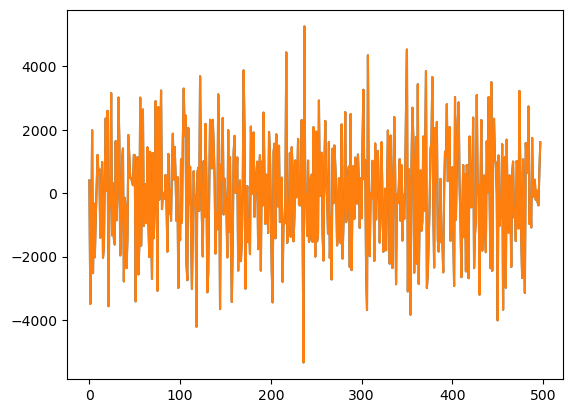

In [14]:
plt.plot(f_meas)
plt.plot(K_interior@c)

In [15]:
pred = evaluate_prediction(x, c, length_scale, root_psi, psi_matrix, boundary, nu, root_b)

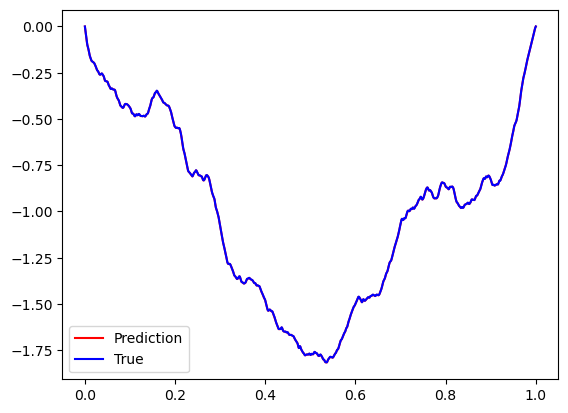

In [16]:
plt.plot(x, pred, color = "red", label = "Prediction")
plt.plot(x, u_values, color = "blue", label = "True")
plt.legend()

## Evaluate the error

In [17]:
n_error = 100
x_error, w_error = roots_legendre(n_error)
x_error, w_error = root_interval(x_error, w_error, jnp.array([lower, upper]))

In [18]:
pred_error = evaluate_prediction(x_error, c, length_scale, root_psi, psi_matrix, boundary, nu, root_b)
u_error = evaluate_function(x_error, coef_u, L)

error = compute_error(pred_error, u_error, w_error)
error

(Array(0.00049365, dtype=float64), Array(0.00044334, dtype=float64))

# Class based solver

In [19]:
# class kernel_linear_solver():
#     def __init__(self, length_scale, psi_matrix, root_psi, boundary,boundary_conditions, nu):

#         self.length_scale = length_scale

#         self.psi_matrix = psi_matrix
#         self.root_psi = root_psi
#         self.boundary_conditions = boundary_conditions
#         self.boundary = boundary

#         self.nu = nu

#     def solve_linear_prob(self, rhs_meas, reg, root_b, L_stiff):
#         self.root_b = root_b

#         # Construct the matrices
#         theta_11, theta_21, theta_22 = theta_blocks(self.boundary,self.psi_matrix, self.root_psi, self.length_scale, self.nu, root_b)
#         theta_12 = theta_21.T
#         K = jnp.block([[theta_11, theta_12], [theta_21, theta_22]])
#         K_interior = jnp.vstack([theta_12, theta_22]).T
#         K_bc = jnp.vstack([theta_11, theta_21]).T

#         self.K, self.K_interior, self.K_bc = K, K_interior, K_bc

#         # Solve the linear problem
#         c = solve_qp(K, K_interior, K_bc, L_stiff, rhs_meas, self.boundary_conditions, reg)
#         self.c = c

#         self.residuals= self.compute_residuals(K_interior, rhs_meas, L_stiff)
#         self.meas = K_interior@c

#     def evaluate_solution(self, x):
#         return evaluate_prediction(x, self.c, self.length_scale, self.root_psi, self.psi_matrix, self.boundary, self.nu, self.root_b)
    
#     def evaluate_solution_parallel(self, x):
#         return vmap_evaluate_prediction(x, self.c, self.length_scale, self.root_psi, self.psi_matrix, self.boundary, self.nu, self.root_b)
    
#     def evaluate_solution_L_psi(self, b_L):
#         K_bc =  jnp.squeeze(vmap_linear_form_K(self.psi_matrix, self.boundary, self.root_psi, self.length_scale, self.nu, b_L), axis = -1)
#         # For some reason the arguments are flipped 
#         K_interior = vmap_bilinear_form_K(self.psi_matrix, self.psi_matrix, self.root_psi, self.root_psi, self.length_scale, self.nu, self.root_b, b_L)
#         #K_interior = vmap_bilinear_form_K(self.psi_matrix, self.psi_matrix, self.root_psi, self.root_psi, self.length_scale, self.nu, b_L, self.root_b)
#         K_eval = jnp.hstack([K_bc, K_interior])
#         self.K_eval_L_psi = K_eval
#         return K_eval@self.c
    
#     def compute_residuals_nl(self, rhs_meas, tau, root_b, L_stiff):

#         non_linear = tau(self.evaluate_solution_parallel(self.root_psi))
#         non_linear = vmap_integrate_f_test_functions(non_linear, psi_matrix)

#         nl_meas = self.evaluate_solution_L_psi(root_b) + non_linear
#         self.non_linear_mes = nl_meas

#         residual= nl_meas + non_linear -rhs_meas

#         # Compute the l_2 norm of the rhs
#         l_2_rhs = jnp.sqrt(jnp.sum(rhs_meas**2))
#         l_2_error = jnp.sqrt(jnp.sum(residual**2))
#         l_2_rel = l_2_error/l_2_rhs

#         # Compute the H_s norm
#         h_s_error = jnp.sqrt((residual)@scipy.linalg.cho_solve(L_stiff, residual))
#         h_s_rhs = jnp.sqrt((rhs_meas)@scipy.linalg.cho_solve(L_stiff, rhs_meas))
#         h_s_rel = h_s_error/h_s_rhs


#         return l_2_error, l_2_rel, h_s_error, h_s_rel

#     def compute_residuals(self, K_interior, rhs_meas, L_stiff):
#         residual = K_interior@self.c -rhs_meas

#         # Compute the l_2 norm of the rhs
#         l_2_rhs = jnp.sqrt(jnp.sum(rhs_meas**2))
#         l_2_error = jnp.sqrt(jnp.sum(residual**2))
#         l_2_rel = l_2_error/l_2_rhs

#         h_s_error = jnp.sqrt((residual)@scipy.linalg.cho_solve(L_stiff, residual))
#         h_s_rhs = jnp.sqrt((rhs_meas)@scipy.linalg.cho_solve(L_stiff, rhs_meas))
#         h_s_rel = h_s_error/h_s_rhs

#         self.residuals = residual
#         return l_2_error, l_2_rel, h_s_error, h_s_rel
    
#     def compute_error(self, x_error, w_error, u_error):
#         pred_error = evaluate_prediction(x_error, self.c, self.length_scale, self.root_psi, self.psi_matrix, self.boundary, self.nu, self.root_b)
#         error = compute_error(pred_error, u_error, w_error)
#         return error


In [20]:
from utils_optim import kernel_linear_solver

We need to evaluate  
$$
 Lu_n + \tau(u_n)
$$

Which means 
$$
[L u_n, \psi] = \sum_{i=1} c_i [L K(x, \psi_i), \psi]
$$

In [21]:
solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, nu)
solver.solve_linear_prob(f_meas, reg, root_b, L_stiff)

In [22]:
zero_nl = lambda x: jnp.zeros_like(x)

In [23]:
solver.residuals, solver.compute_error(x_error, w_error, u_error)

((Array(0.13702494, dtype=float64),
  Array(3.63500023e-06, dtype=float64),
  Array(0.00314189, dtype=float64),
  Array(9.9743573e-07, dtype=float64)),
 (Array(0.00049365, dtype=float64), Array(0.00044334, dtype=float64)))

In [24]:
solver.compute_residuals_nl(f_meas, zero_nl, root_b, L_stiff)

(Array(0.13702494, dtype=float64),
 Array(3.63500023e-06, dtype=float64),
 Array(0.00314189, dtype=float64),
 Array(9.97435729e-07, dtype=float64))

In [25]:
solver.compute_residuals_nl(f_meas, zero_nl, root_b, L_stiff)

(Array(0.13702494, dtype=float64),
 Array(3.63500023e-06, dtype=float64),
 Array(0.00314189, dtype=float64),
 Array(9.97435729e-07, dtype=float64))

In [26]:
jnp.allclose(solver.evaluate_solution_L_psi(root_b), solver.meas)

Array(True, dtype=bool)

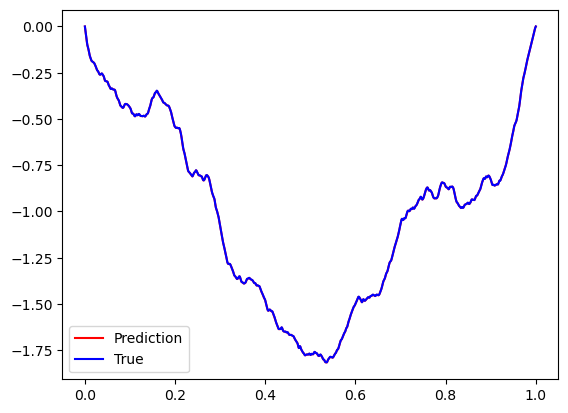

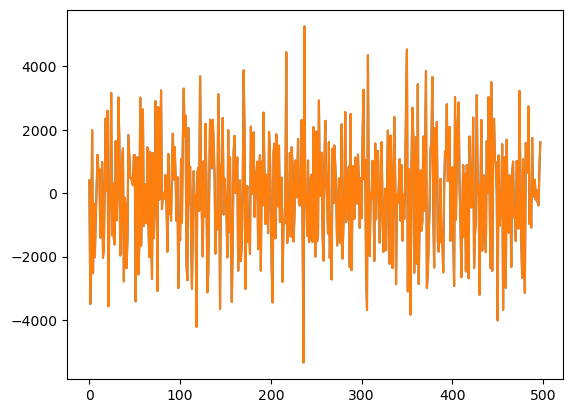

In [27]:
pred = solver.evaluate_solution(x)

plt.plot(x, pred, color = "red", label = "Prediction")
plt.plot(x, u_values, color = "blue", label = "True")
plt.legend()

plt.figure()
plt.plot(solver.meas, label = "Prediction")
plt.plot(f_meas, label = "True")

(Array(2.30272279e-06, dtype=float64), Array(6.10866761e-11, dtype=float64), Array(5.46087686e-08, dtype=float64), Array(1.73362742e-11, dtype=float64))


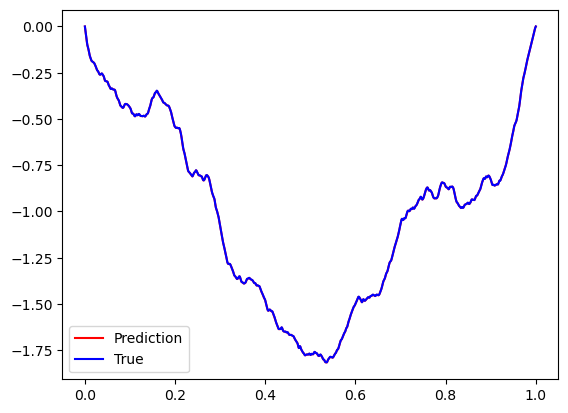

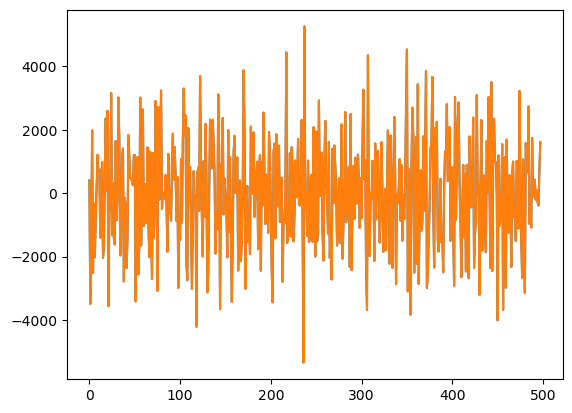

In [28]:
# With no regularization this time 

solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, nu)
solver.solve_linear_prob(f_meas, None, root_b, L_stiff)

print(solver.compute_residuals_nl(f_meas, zero_nl, root_b, L_stiff))

pred = solver.evaluate_solution(x)

plt.plot(x, pred, color = "red", label = "Prediction")
plt.plot(x, u_values, color = "blue", label = "True")
plt.legend()

plt.figure()
plt.plot(solver.meas, label = "Prediction")
plt.plot(f_meas, label = "True")


# Semilinear elliptic PDE


With the Gauss-Newton iteration, we need to solve 

\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n)  - f, \boldsymbol{\psi}]^\intercal \Theta^{-1} [\mathcal{P}(u_n) +\mathcal{P}'(u_n)(v - u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

The case we wish to address is 

\begin{align}
&\mathcal{P}(u) = Lu + \tau(u)\\
&\mathcal{P}'(u) = Lu + \tau'(u)
\end{align}

In which case the above problem is 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v - ( f -\tau(u_n) + \tau'(u_n)u_n), \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

Denote $r_n = f -\tau(u_n) + \tau'(u_n)u_n$. Then
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,[Lv + \tau'(u_n)v - r_n, \boldsymbol{\psi}]^\intercal \Theta^{-1} [Lv + \tau'(u_n)v -r_n, \boldsymbol{\psi}] + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}

Acutally we will have 
\begin{align}
\text{argmin}_{v\in \mathcal{H}_K} &\,\Big([Lv + \tau'(u_n)v, \boldsymbol{\psi}] - \big([f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi] \big)\Big)^\intercal \Theta^{-1}\Big([Lv + \tau'(u_n)v, \boldsymbol{\psi}] - \big([f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi] \big)\Big) + \gamma ||v||^2_{\mathcal{H}_K}\\
   &\text{s.t. } v(x_j) = g(x_j) \quad\text{for }j=1,\dots,M,
\end{align}


At each iteration, we need to 

1. Compute $r_n : = [f, \psi] + [ \tau'(u_n)u_n - \tau(u_n), \psi]$
2. Build the new operator/kernel matrix using $\tau'(u_n)$.
3. Solve the system.

In [30]:
tau = lambda x : x**3/3
# We hardcode the derivative of tau (one could use autograd to compute it)
tau_prime = lambda x : x**2
b = lambda x: jnp.ones_like(x)

\begin{aligned}
 -\nu \Delta u -u + u^3 &= \xi \quad x \in \Omega\\
u &= 0 \quad x \in \partial \Omega
\end{aligned}

3.1


Text(0.5, 1.0, 'Function f')

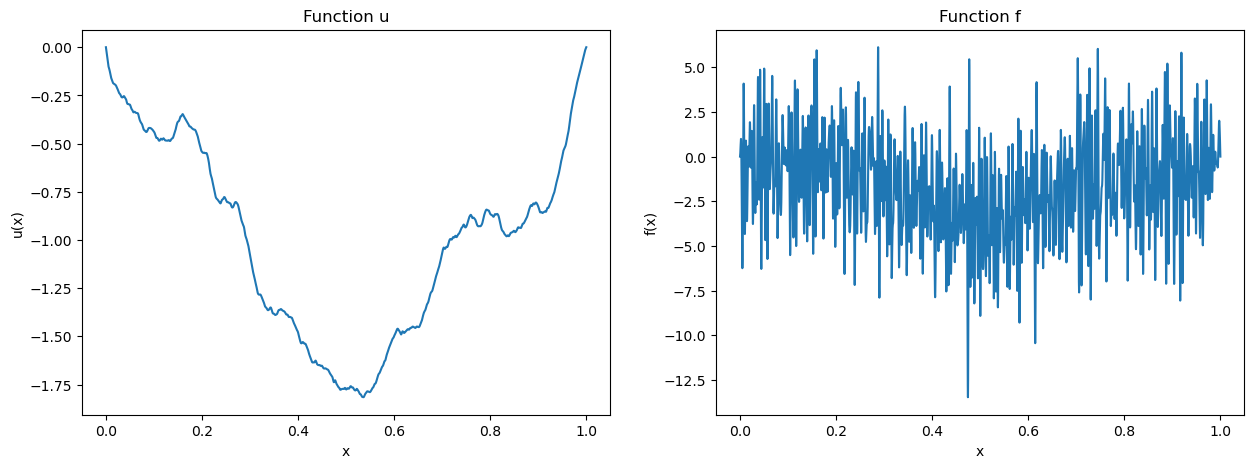

In [31]:
# Create the a semilinear elliptic PDE

nu = 1e-3
# draw random values for the coefficients
key = random.PRNGKey(54)
n_coef = 500

s = 1
alpha = 2*s+1 + 0.1
print(alpha)
decay_u = alpha/2
L = 1 # Lenght of the domain
coef_u =  jnp.ones(shape = (1, ))/(jnp.arange(1, n_coef+1)**(decay_u)) #jnp.ones(shape = (1, ))#random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))

coef_u = random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))
coef_f_linear = coef_u*(nu*jnp.arange(1, n_coef+1)**(2)*jnp.pi**2*L**2)

#x = jnp.linspace(0, L, 2000)
u_values = evaluate_function(x, coef_u, L=L)
f_values = evaluate_function(x, coef_f_linear, L=L) + b(x)*u_values + tau(u_values)
u_error = evaluate_function(x_error, coef_u, L)



# Create 2 plots for the  function u and f
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values)
ax[0].set_xlabel("x")
ax[0].set_ylabel("u(x)")
ax[0].set_title("Function u")

ax[1].plot(x, f_values)
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].set_title("Function f")

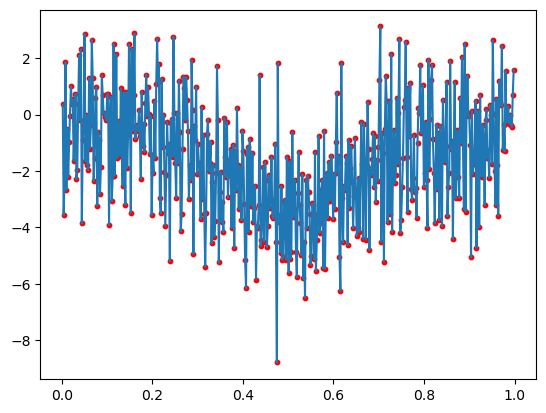

In [32]:
# Define the support of the test function 
support = jnp.array([centers - epsilon
                     , centers + epsilon]).T

from scipy.special import roots_legendre
n_order = 10
x_q, w_q = roots_legendre(n_order)
x_interval, w_interval = vmap_root_interval(x_q, w_q, support)

from utils_rough_pde import vmap_integrate_f_test_functions
# Create measurements of f 
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)
psi_matrix = vmap_tent_vector(root_psi, epsilon, centers)
psi_matrix = psi_matrix * w_psi
# Create the measurements of f
f_quad = evaluate_function(root_psi, coef_f_linear, L) + b(root_psi)*evaluate_function(root_psi, coef_u, L) + tau(evaluate_function(root_psi, coef_u, L))
f_meas = vmap_integrate_f_test_functions(f_quad, psi_matrix)

plt.plot(centers, f_meas)
plt.scatter(centers, f_meas, color='r', s = 10)

In [33]:
# Create the array of b values
root_b = b(root_psi)

(Array(249.14183239, dtype=float64), Array(4.34096002, dtype=float64), Array(1401.07542366, dtype=float64), Array(4.81084289, dtype=float64))


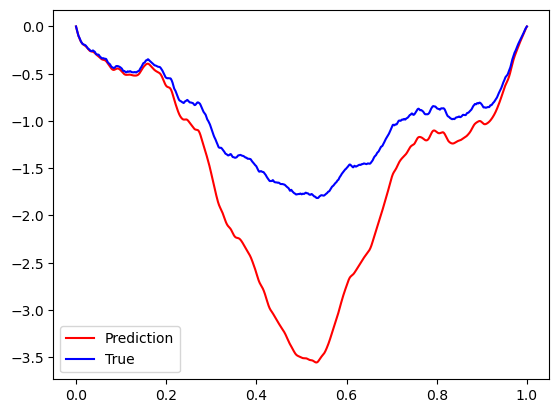

In [34]:
# First solve using the linear solver (for an initial guess)
reg = 1e-5
length_scale = 0.1
solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, nu)
solver.solve_linear_prob(f_meas, reg, root_b, L_stiff)
u_pred = solver.evaluate_solution(x)
#print(solver.compute_error(x_error, w_error, u_error))

print(solver.compute_residuals_nl(f_meas, tau, root_b, L_stiff))

plt.plot(x, u_pred, color = "red", label = "Prediction")
plt.plot(x, u_values, color = "blue", label = "True")
plt.legend()

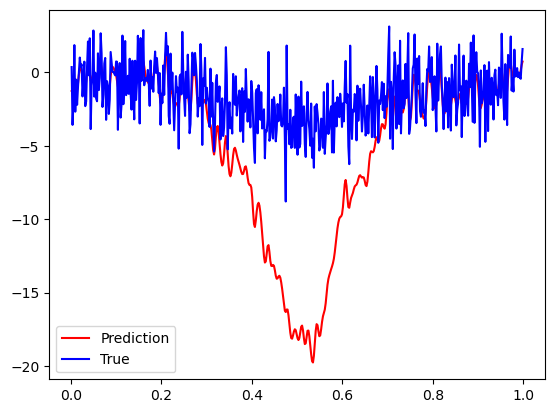

In [35]:
plt.plot(centers, solver.non_linear_mes, color = "red", label = "Prediction")
plt.plot(centers, f_meas, color = "blue", label = "True")
plt.legend()

In [36]:
reg = 1e-5
length_scale = 0.1

root_train = root_b + random.uniform(key, shape = root_b.shape)*0.5
solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, nu)
solver.solve_linear_prob(f_meas, reg, root_train, L_stiff)
solver.compute_residuals_nl(f_meas, tau, root_b, L_stiff)

(Array(132.89868727, dtype=float64),
 Array(2.31558018, dtype=float64),
 Array(695.04935756, dtype=float64),
 Array(2.3865762, dtype=float64))

In [37]:
i = -10
j = 1
bilinear_form_K(psi_matrix[i], psi_matrix[j], root_psi[i], root_psi[j], length_scale, nu,root_train[j] , root_b[i])

Array(3.21853877e-08, dtype=float64)

In [38]:
solver.K_eval_L_psi[:, 2:][i,j]

Array(3.21853877e-08, dtype=float64)

In [39]:
solver.K_eval_L_psi[:, 2:][i,j]

Array(3.21853877e-08, dtype=float64)

In [40]:
solver.K_eval_L_psi.shape

(498, 500)

In [41]:
# u_pred_root = solver.evaluate_solution_parallel(root_psi)

# def compute_meas_update(u_root, psi_matrix):
#     root_values =  tau_prime(u_root)*u_root - tau(u_root)
#     return vmap_integrate_f_test_functions(root_values, psi_matrix)

# meas_update = compute_meas_update(u_pred_root, psi_matrix)

In [42]:
from pdb import set_trace as bp

We will iteratively solve
Let $r_n = \xi - \mathcal{P}(u_n)$
\begin{align}
    & \mathcal{P}'(u_n)u_{n+1} = \alpha r_n +  \mathcal{P}'(u_n)u_n \\
    &u_{n+1}(x_j) = g(x_j)
\end{align}
This yields the problem 
\begin{align}
    u_{n+1}  = \text{armin}_{v\in \mathcal{H}_K} & \,[\mathcal{P}'(u_n)v  - \big(\alpha r_n + \mathcal{P}'(u_n)u_n\big), \boldsymbol{\psi}]^2_{A^{-1}} + \gamma ||v||^2\\
    &\text{s.t. }v(x_j)  = g(x_j) \quad\text{for }j=1,\dots,M.
\end{align}

For calrity, we rewrite this as 

\begin{align}
    & \mathcal{P}'(u_n)u_{n+1} = \alpha ( \xi - Lu_n - \tau(u_n)) +  Lu_n + \tau'(u_n)u_n \\
    &u_{n+1}(x_j) = g(x_j)
\end{align}

In the case where $\alpha = 1$, we get 

\begin{align}
    & \mathcal{P}'(u_n)u_{n+1} = \xi - \tau(u_n) + \tau'(u_n)u_n \\
    &u_{n+1}(x_j) = g(x_j)
\end{align}

In [43]:
from utils_optim import Gauss_Newton_solver_variable, Gauss_Newton_solver

In [44]:

# def compute_frechet_proj(u_root, psi_matrix, tau_prime):
#     root_values =  tau_prime(u_root)*u_root
#     return vmap_integrate_f_test_functions(root_values, psi_matrix)

# def Gauss_Newton_solver(lr, L_stiff, f_meas, b, tau, tau_prime, psi_matrix, root_psi,linear_solver, reg, n_iter = 10):

#     rhs_meas = jnp.copy(f_meas)
#     root_b = b(root_psi)
#     root_linearization = jnp.copy(root_b)

#     prev_error = jnp.inf

#     for i in range(n_iter):
#         # Do a linear solve
#         linear_solver.solve_linear_prob(rhs_meas, reg, root_linearization, L_stiff)
#         # Compute the residuals
#         l_2_error, l_2_rel, h_s_error, h_s_rel = linear_solver.compute_residuals_nl(f_meas, tau, root_b, L_stiff)
#         if h_s_rel > prev_error:
#             lr = lr/10
#             print("Decreasing the learning rate to {}".format(lr))
#             rhs_meas = lr*residual +linear_part

#         else:
#             improvement = prev_error - h_s_rel
#             prev_error = h_s_rel
#             print("Iteration {}, current error: {} H^-s, {} l_2. Improvement {}".format(i+1, jnp.round(h_s_rel,5), jnp.round(l_2_rel,5), jnp.round(improvement, 5))) 

#             # Update the rhs 
#             u_pred_root = linear_solver.evaluate_solution_parallel(root_psi)
#             linear_proj = compute_frechet_proj(u_pred_root, psi_matrix, tau_prime)
#             residual = f_meas - linear_solver.non_linear_mes
#             linear_part = linear_solver.evaluate_solution_L_psi(root_b) + linear_proj
#             rhs_meas = lr*residual + linear_part

#             # # lr = 1.0 case
#             # root_values = tau_prime(u_pred_root)*u_pred_root - tau(u_pred_root)
#             # rhs_1 = f_meas +  vmap_integrate_f_test_functions(root_values, psi_matrix)

#             # print(jnp.sqrt(jnp.sum((rhs_1 - rhs_meas)**2)))

#             # Update the operator by updating the roots of b
#             root_linearization = b(root_psi) +  tau_prime(u_pred_root)
        
#         if lr < 1e-10:
#             print("Learning rate too small, exiting")
#             break
#         if improvement < 1e-4:
#             print("Improvement too small, exiting")
#             break

    
#     return linear_solver
        

In [45]:
b(root_psi)

Array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float64)

In [46]:
# length_scale = 0.2
# solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, nu)
# lr = 1e-5
# reg = 1e-5
# solver_opt = Gauss_Newton_solver(lr, L_stiff, f_meas, b, tau, tau_prime, psi_matrix, root_psi,solver, reg, n_iter = 15)

In [47]:
length_scale = 0.1
linear_solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, nu)
lr = 1.0
reg = 1e-8
#solver_opt = Gauss_Newton_solver_variable(lr, L_stiff, f_meas, b, tau, tau_prime, psi_matrix, root_psi, linear_solver, reg, n_iter = 50)

solver_opt = Gauss_Newton_solver(L_stiff, f_meas, b, tau, tau_prime, psi_matrix, root_psi, linear_solver, reg, n_iter = 50)

Iteration 1, current error: 4.810840000000001 H^-s, 4.34084 l_2. Improvement nan
Iteration 2, current error: 1.4144400000000001 H^-s, 1.38542 l_2. Improvement 0.70599
Iteration 3, current error: 0.54803 H^-s, 0.7346400000000001 l_2. Improvement 0.61255
Iteration 4, current error: 0.40940000000000004 H^-s, 0.6592 l_2. Improvement 0.25296
Iteration 5, current error: 0.40355 H^-s, 0.65636 l_2. Improvement 0.014300000000000002
Iteration 6, current error: 0.40353000000000006 H^-s, 0.6563500000000001 l_2. Improvement 4e-05
Increase in error, exiting


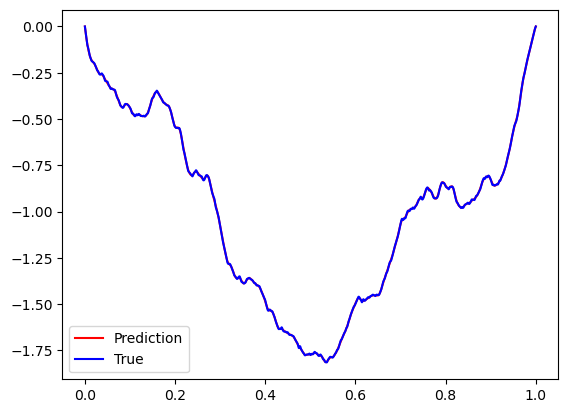

In [48]:
u_pred = solver_opt.evaluate_solution(x)

plt.plot(x, u_pred, color = "red", label = "Prediction")
plt.plot(x, u_values, color = "blue", label = "True")
plt.legend()

In [49]:
print(solver_opt.compute_error(x_error, w_error, u_error))

(Array(0.00290864, dtype=float64), Array(0.0026122, dtype=float64))


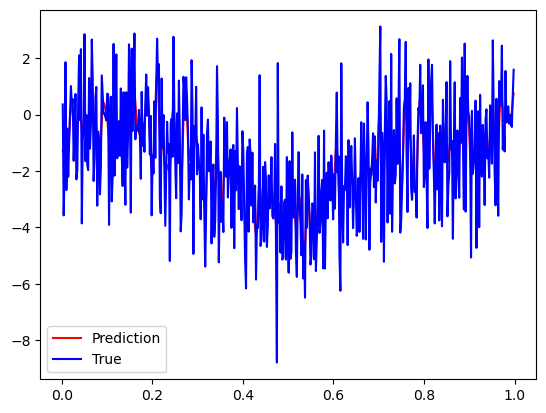

In [50]:
plt.plot(centers, solver_opt.non_linear_mes, color = "red", label = "Prediction")
plt.plot(centers, f_meas, color = "blue", label = "True")
plt.legend()